<a href="https://colab.research.google.com/github/vinayykkumar/Visionary-Advanced-Image-Recognition-for-the-Next-Era_Infosys_Internship_Oct2024/blob/durga_prasad/Face_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
import cv2
import numpy as np
from PIL import Image, ImageEnhance, ImageOps
import random


def augment_image(image):
    """
    Apply random augmentations to an image using Pillow.
    """
    # Random rotation
    if random.random() > 0.5:
        angle = random.uniform(-30, 30)  # Rotate between -30 and 30 degrees
        image = image.rotate(angle, expand=True)

    # Random horizontal flip
    if random.random() > 0.5:
        image = ImageOps.mirror(image)

    # Random brightness adjustment
    if random.random() > 0.5:
        enhancer = ImageEnhance.Brightness(image)
        factor = random.uniform(0.8, 1.2)  # Brightness factor
        image = enhancer.enhance(factor)

    # Random zoom (crop and resize back)
    if random.random() > 0.5:
        width, height = image.size
        zoom_factor = random.uniform(0.8, 1.2)  # Zoom in/out factor
        new_width = int(width * zoom_factor)
        new_height = int(height * zoom_factor)
        image = image.resize((new_width, new_height), Image.Resampling.LANCZOS)  # Use Resampling.LANCZOS
        if zoom_factor > 1:
            # Crop to original size
            left = (new_width - width) // 2
            top = (new_height - height) // 2
            image = image.crop((left, top, left + width, top + height))
        else:
            # Pad to original size
            image = ImageOps.pad(image, (width, height), color=(0, 0, 0))

    return image

In [ ]:
def preprocess_and_augment_with_pillow(input_dir, output_dir, img_size=(128, 128), augmentations=4):
    """
    Preprocesses and augments images using OpenCV and Pillow.

    Args:
        input_dir (str): Path to the input dataset directory.
        output_dir (str): Path to the output directory for preprocessed and augmented images.
        img_size (tuple): Target size for resizing the images (width, height).
        augmentations (int): Number of augmented images to generate per input image.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Iterate through each person's folder in the dataset
    for person_name in os.listdir(input_dir):
        person_folder = os.path.join(input_dir, person_name)
        output_person_folder = os.path.join(output_dir, person_name)

        if not os.path.isdir(person_folder):
            continue  # Skip files, only process directories

        # Create corresponding output directory for each person if it doesn't exist
        if not os.path.exists(output_person_folder):
            os.makedirs(output_person_folder)

        # Process each image in the person's folder
        for img_name in os.listdir(person_folder):
            img_path = os.path.join(person_folder, img_name)

            # Read the image using OpenCV
            image = cv2.imread(img_path)
            if image is None:
                print(f"Warning: Could not read image {img_path}")
                continue

            # Step 1: Resize the image
            image_resized = cv2.resize(image, img_size)

            # Step 2: Apply Bilateral Filter for noise reduction while preserving edges
            image_bilateral = cv2.bilateralFilter(image_resized, d=9, sigmaColor=75, sigmaSpace=75)

            # Step 3: Convert to grayscale for thresholding
            gray = cv2.cvtColor(image_bilateral, cv2.COLOR_BGR2GRAY)

            # Step 4: Apply simple thresholding for background removal
            _, thresholded = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

            # Apply the threshold mask to the original image
            foreground = cv2.bitwise_and(image_bilateral, image_bilateral, mask=thresholded)

            # Save the preprocessed image
            preprocessed_path = os.path.join(output_person_folder, f"processed_{img_name}")
            cv2.imwrite(preprocessed_path, foreground)
            print(f"Preprocessed and saved: {preprocessed_path}")

            # Convert to Pillow Image for augmentation
            pil_image = Image.fromarray(cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB))

            # Step 5: Apply data augmentation with Pillow
            for i in range(augmentations):
                augmented_image = augment_image(pil_image)  # Apply random augmentations
                aug_img_path = os.path.join(output_person_folder, f"aug_{i}_{img_name}")
                augmented_image.save(aug_img_path)
                print(f"Augmented and saved: {aug_img_path}")
# Define input and output directories
input_directory = "//content//gdrive//MyDrive//My dataset"          # Replace with the path to your dataset folder
output_directory = "augmented_dataset"           # Where augmented images will be saved

# Call the preprocessing and augmentation function
preprocess_and_augment_with_pillow(input_directory, output_directory)

In [12]:
import os

def count_images_in_directory(directory):
    """
    Counts the number of image files in a directory (including subdirectories).

    Args:
        directory (str): Path to the directory to count images in.

    Returns:
        int: The total number of image files.
    """
    count = 0
    for root, _, files in os.walk(directory):
        count += len([file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))])
    return count

# Define input and output directories
input_directory = "//content//gdrive//MyDrive//My dataset"  # Replace with the path to your dataset folder
output_directory = "augmented_dataset"                      # Replace with the path to your augmented dataset folder

# Count the images before and after augmentation
num_images_before = count_images_in_directory(input_directory)
num_images_after = count_images_in_directory(output_directory)

print(f"Number of images before augmentation: {num_images_before}")
print(f"Number of images after augmentation: {num_images_after}")


Number of images before augmentation: 1168
Number of images after augmentation: 5840


In [4]:
import os
import numpy as np
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
def load_dataset(dataset_dir, img_size=(128, 128)):
    """
    Load images and labels from the specified dataset directory.

    Args:
        dataset_dir (str): Path to dataset directory.
        img_size (tuple): Target size for resizing images.

    Returns:
        tuple: Tuple containing image data (X), labels (y), and LabelEncoder instance.
    """
    X, y = [], []
    label_names = []

    for person_name in os.listdir(dataset_dir):
        person_folder = os.path.join(dataset_dir, person_name)
        if not os.path.isdir(person_folder):
            continue

        label_names.append(person_name)
        for img_name in os.listdir(person_folder):
            img_path = os.path.join(person_folder, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, img_size)
            X.append(img)
            y.append(person_name)

    X = np.array(X, dtype='float32') / 255.0  # Normalize images
    y = np.array(y)

    # Encode labels to integers
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    return X, y, label_encoder

In [6]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

def build_improved_model(input_shape, num_classes, learning_rate=0.001, weight_decay=1e-4):
    """
    Build and compile an improved CNN model with Batch Normalization and L2 regularization.

    Args:
        input_shape (tuple): Shape of the input images.
        num_classes (int): Number of output classes.
        learning_rate (float): Learning rate for the optimizer.
        weight_decay (float): Weight decay (L2 regularization factor).

    Returns:
        model: Compiled CNN model.
    """
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape,
               kernel_regularizer=regularizers.l2(weight_decay)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Fourth Convolutional Block
        Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Global Average Pooling and Dense Layers
        GlobalAveragePooling2D(),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
        Dropout(0.5),
        Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(weight_decay))
    ])

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [7]:
def plot_training_history(history):
    """
    Plot training and validation accuracy and loss.

    Args:
        history: Training history object from Keras model.
    """
    # Accuracy Plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=range(1, len(history.history['accuracy']) + 1), y=history.history['accuracy'], label='Training Accuracy', color='blue')
    sns.lineplot(x=range(1, len(history.history['val_accuracy']) + 1), y=history.history['val_accuracy'], label='Validation Accuracy', color='red')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Loss Plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=range(1, len(history.history['loss']) + 1), y=history.history['loss'], label='Training Loss', color='blue')
    sns.lineplot(x=range(1, len(history.history['val_loss']) + 1), y=history.history['val_loss'], label='Validation Loss', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 32s 93ms/step - accuracy: 0.3393 - loss: 1.6311 - val_accuracy: 0.2774 - val_loss: 2.2233
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.4763 - loss: 1.2512 - val_accuracy: 0.2354 - val_loss: 2.8344
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.5392 - loss: 1.1268 - val_accuracy: 0.4221 - val_loss: 1.4577
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5927 - loss: 1.0383 - val_accuracy: 0.5342 - val_loss: 1.0539
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6168 - loss: 0.9964 - val_accuracy: 0.5420 - val_loss: 1.1631
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6196 - loss: 0.9716 - val_accuracy: 0.5711 - val_loss: 1.0999
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6712 - loss: 0.8574 - val_accuracy: 0.6926 - val_loss: 0.8039
Epoch 8/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7054 - loss: 0.7989 - val_acc

Final Training Accuracy: 91.46%
Final Validation Accuracy: 88.44%
Model saved at improved_face_recognition_model.h5


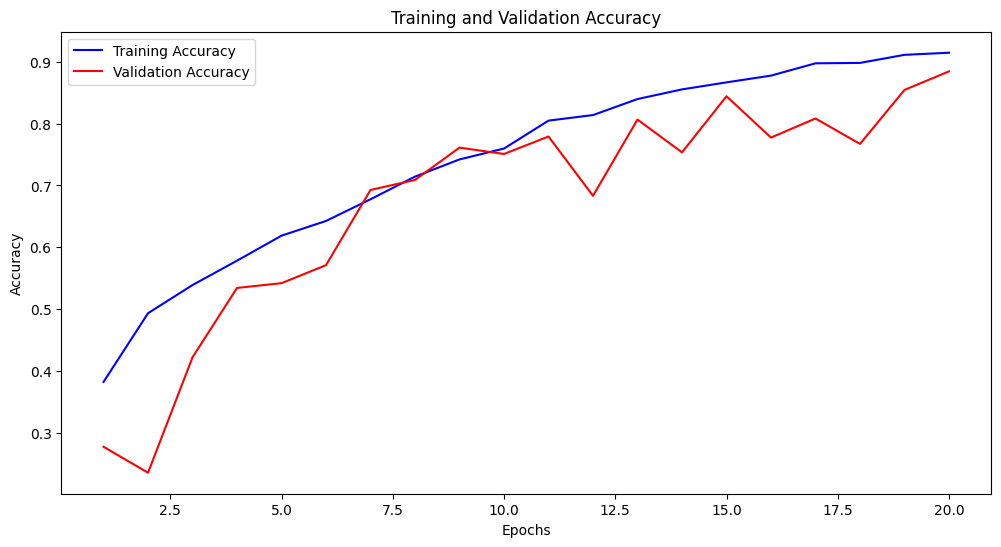

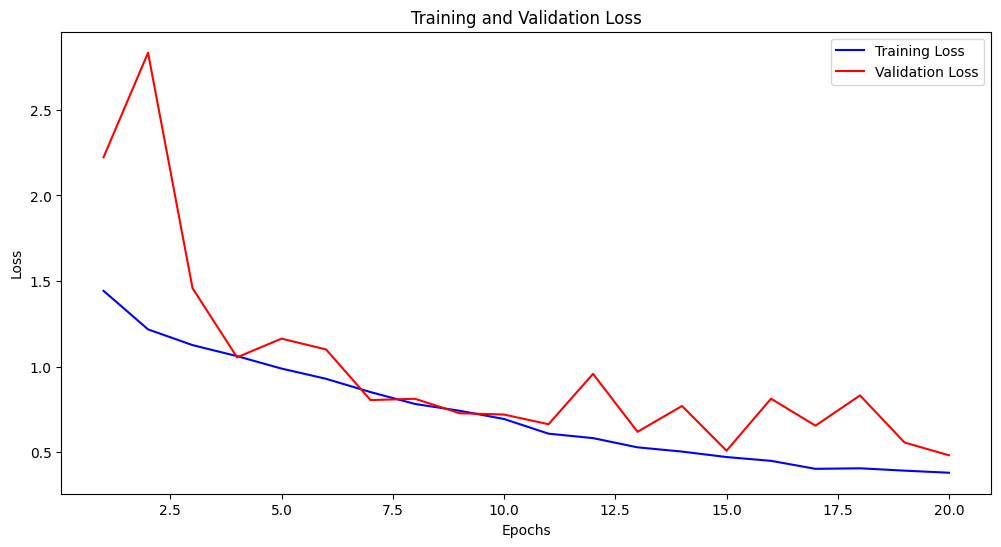

In [11]:
# Main function to train the improved model
def train_model(dataset_dir, output_model_path, img_size=(128, 128), learning_rate=0.001, weight_decay=1e-4):
    """
    Train and save a face recognition model.

    Args:
        dataset_dir (str): Path to dataset directory.
        output_model_path (str): Path to save the trained model.
        img_size (tuple): Target size for resizing images.
        learning_rate (float): Learning rate for the optimizer.
        weight_decay (float): Weight decay (L2 regularization factor).
    """
    # Load dataset
    X, y, label_encoder = load_dataset(dataset_dir, img_size)
    num_classes = len(np.unique(y))

    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Build and train the improved model
    model = build_improved_model(
        input_shape=(img_size[0], img_size[1], 3),
        num_classes=num_classes,
        learning_rate=learning_rate,
        weight_decay=weight_decay
    )
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=25)

    # Extract final accuracy values
    final_train_accuracy = history.history['accuracy'][-1] * 100  # Convert to percentage
    final_val_accuracy = history.history['val_accuracy'][-1] * 100  # Convert to percentage

    # Print training and validation accuracy as percentages
    print(f"Final Training Accuracy: {final_train_accuracy:.2f}%")
    print(f"Final Validation Accuracy: {final_val_accuracy:.2f}%")

    # Save the model and label encoder
    model.save(output_model_path)
    np.save(output_model_path + "_labels.npy", label_encoder.classes_)
    print(f"Model saved at {output_model_path}")

    # Plot training history
    plot_training_history(history)

# Example Usage
dataset_directory = "augmented_dataset"  # Path to dataset
output_model_file = "improved_face_recognition_model.h5"  # Path to save the model

train_model(dataset_directory, output_model_file)


In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def load_model_and_generate_confusion_matrix(model_path, dataset_dir, img_size=(128, 128)):
    """
    Load a trained model and generate a confusion matrix on the validation set.

    Args:
        model_path (str): Path to the trained model file.
        dataset_dir (str): Path to the dataset directory.
        img_size (tuple): Target size for resizing images.
    """
    # Load model and label encoder
    model = load_model(model_path)
    label_encoder = np.load(model_path + "_labels.npy", allow_pickle=True)

    # Load dataset
    X, y, _ = load_dataset(dataset_dir, img_size)

    # Split dataset into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Make predictions on the validation set
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Decode label indices to class names
    class_names = label_encoder

    # Print classification report
    print(classification_report(y_val, y_pred_classes, target_names=class_names))

    # Plot confusion matrix
    cm = confusion_matrix(y_val, y_pred_classes)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Example Usage
model_path = "improved_face_recognition_model.h5"  # Path to your trained model
dataset_directory = "augmented_dataset"  # Path to dataset

load_model_and_generate_confusion_matrix(model_path, dataset_directory)


In [ ]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

def test_image_with_debugging(model_path, label_encoder_path, image_path, img_size=(128, 128)):
    """
    Test a single image with the trained model and display debug information.

    Args:
        model_path (str): Path to the trained model file.
        label_encoder_path (str): Path to the label encoder's saved classes.
        image_path (str): Path to the image to be tested.
        img_size (tuple): Target size for resizing the image.

    Returns:
        None
    """
    # Load the trained model
    model = load_model(model_path)

    # Load the label encoder
    label_classes = np.load(label_encoder_path, allow_pickle=True)

    # Load and preprocess the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image at {image_path} could not be loaded.")

    # Display the original image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Input Image")
    plt.axis("off")
    plt.show()

    img_resized = cv2.resize(img, img_size)  # Resize to match model input
    img_normalized = img_resized.astype('float32') / 255.0  # Normalize
    img_batch = np.expand_dims(img_normalized, axis=0)  # Add batch dimension

    # Make predictions
    predictions = model.predict(img_batch)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_label = label_classes[predicted_class_index]
    prediction_confidence = predictions[0][predicted_class_index]

    # Display results
    print(f"Predicted Label: {predicted_label}")
    print(f"Prediction Confidence: {prediction_confidence:.2f}")

    # Display full prediction probabilities
    for idx, label in enumerate(label_classes):
        print(f"Class: {label}, Probability: {predictions[0][idx]:.4f}")

# Example usage
model_path = "/content/improved_face_recognition_model.h5"  # Path to your saved model
label_encoder_path = "/content/improved_face_recognition_model.h5_labels.npy"  # Path to saved label classes
image_path = "/content/download (1).jpeg"  # Path to the image you want to test

predicted_label = test_image_with_debugging(model_path, label_encoder_path, image_path)
